In [156]:
import pandas as pd
import numpy as np
import Dora 
import time
import matplotlib.pyplot as plt
from numba import njit
import cython_funcs

import yfinance as yf
import matplotlib.pyplot as plt

import datetime
from datetime import timedelta

from scipy.stats import norm
import black_scholes
from math import log, sqrt, exp
from math import erf

#### Task 1

In [3]:
df = pd.read_csv("winequality-red.csv", sep=';')

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
def compute_python(x, y):
    res = []
    for i in range(len(x)):
        val = np.sinh(np.sqrt(x[i]**2 + y[i]**2) + np.sin(x[i]) * np.log1p(y[i]))
        res.append(val)
    return res

@njit
def compute_numba(x, y):
    res = np.empty_like(x)
    for i in range(len(x)):
        res[i] = np.sinh(np.sqrt(x[i]**2 + y[i]**2) + np.sin(x[i]) * np.log1p(y[i]))
    return res

In [6]:
x = df["chlorides"].to_numpy(dtype=np.float64)
y = df["density"].to_numpy(dtype=np.float64)

In [7]:
start = time.time()
res_nb = compute_python(x, y)
print("Numba time:", time.time() - start)

Numba time: 0.00897526741027832


In [130]:
start = time.time()
res_nb = compute_numba(x, y)
print("Numba time:", time.time() - start)

Numba time: 0.0005218982696533203


In [74]:
start = time.time()
res_cy = cython_funcs.compute_cython(x, y)
print("Cython time:", time.time() - start)

Cython time: 0.0059986114501953125


#### Task 2 

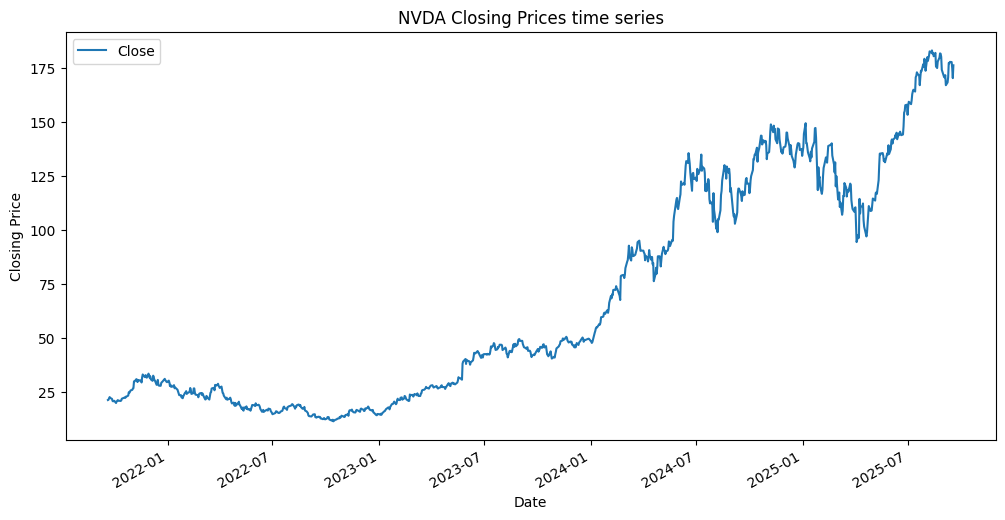

In [ ]:
stock = 'NVDA'
ticker = yf.Ticker(stock)
today = datetime.date.today()

stock_data = ticker.history(
    interval='1d', 
    start=today-timedelta(days=4*365), 
    end=today
    )

# Plotting the closing price `Close` over the last 4 years
stock_data.plot(y='Close', figsize=(12,6))
plt.title(f'{stock} Closing Prices time series')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

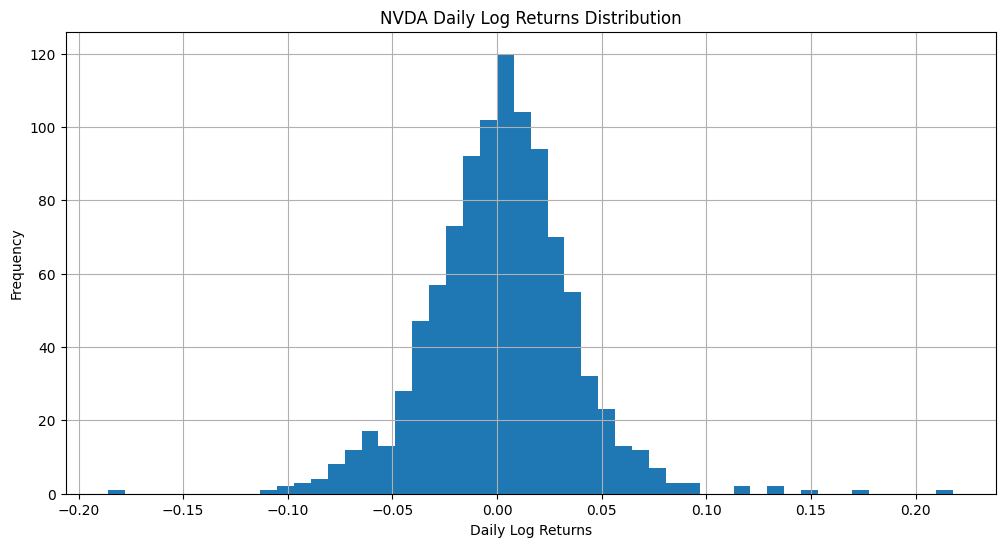

In [143]:
# Returns distributions
daily_returns = stock_data['Close'].pct_change()

# log returns distributions
daily_log_returns = np.log(daily_returns+1)

# Plotting histogram of the log-returns
daily_log_returns.hist(bins=50, figsize=(12,6))
plt.title(f'{stock} Daily Log Returns Distribution')
plt.xlabel('Daily Log Returns')
plt.ylabel('Frequency')
plt.show()

In [144]:
# get all option expirey date
expirations = ticker.options

# Selecting element 7 as the expiry date i.e. 2025-01-17
# list options with a chosen expirey
expiry = expirations[7]

options = ticker.option_chain(date = expiry)

# Get the option with index 2
option = options.calls.iloc[2] 
purchase_date = option.lastTradeDate # Date the Contract was priced
time_to_maturity = pd.Timestamp(expiry + ' 16:00:00', tz='EST') - purchase_date.tz_convert('EST') # The number of days to maturity


In [145]:
# stock price when option was traded
minute_data = ticker.history(
    interval='1m', 
    start=purchase_date-timedelta(minutes=1), 
    end=purchase_date+timedelta(minutes=5)
    )

# Price of the stock
stock_price = minute_data.iloc[1].Close

print(f'Current stock price: {stock_price:.2f}')

Current stock price: 178.05


In [146]:
# Creating a ticker for `^IRX`
treasury_3m = yf.Ticker('^IRX')

# Risk Free Rate on date the option was purchased (on `purchase_date`)
minute_history_bond = treasury_3m.history(
    interval='1m', 
    start=purchase_date-timedelta(minutes=1), 
    end=purchase_date+timedelta(minutes=5)
    )

# Risk free rate
usbond = minute_history_bond.iloc[0].Close

print(f'Risk Free Rate: {usbond:.2f}%')

Risk Free Rate: 3.93%


In [ ]:
stock_data["log_return"] = np.log(stock_data["Close"] / stock_data["Close"].shift(1))

daily_vol = stock_data["log_return"].std()

volatility = daily_vol * np.sqrt(252)
print("Annualized volatility:", volatility)

Annualized volatility: 0.5452976614958933


In [ ]:
def BlackScholes(S, K, T, r, sigma):
    d1 = ((r + 0.5*sigma**2)*T + np.log(S/K))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    C = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return C

@njit
def BlackScholes_numba(S, K, T, r, sigma):
    def norm_cdf(x):
        return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))

    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    C = S*norm_cdf(d1) - K*exp(-r*T)*norm_cdf(d2)
    return C

Python: 12.5061 s
Numba:  0.1850 s
Cython: 0.0214 s


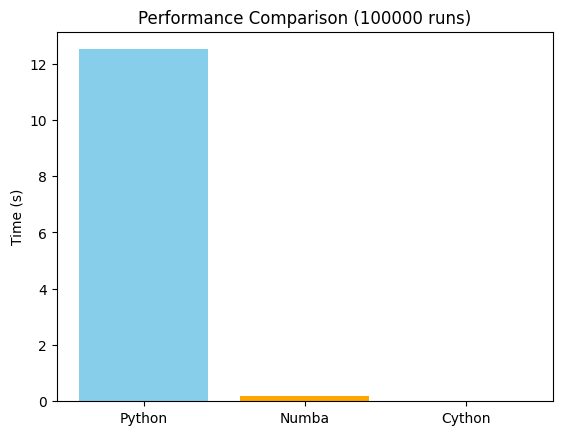

In [ ]:
S = stock_price         
K = option.strike       
T = time_to_maturity.days/365
r = usbond/100
sigma = volatility

runs = 100000

# Python
start = time.time()
for _ in range(runs):
    BlackScholes(S, K, T, r, sigma)
t_py = time.time() - start

# Numba
start = time.time()
for _ in range(runs):
    BlackScholes_numba(S, K, T, r, sigma)
t_numba = time.time() - start

# Cython
start = time.time()
for _ in range(runs):
    black_scholes.BlackScholes_cy(S, K, T, r, sigma)
t_cy = time.time() - start

# Вивід
print(f"Python: {t_py:.4f} s")
print(f"Numba:  {t_numba:.4f} s")
print(f"Cython: {t_cy:.4f} s")

# Побудова графіку
times = [t_py, t_numba, t_cy]
labels = ["Python", "Numba", "Cython"]

plt.bar(labels, times, color=["skyblue","orange","green"])
plt.ylabel("Time (s)")
plt.title(f"Performance Comparison ({runs} runs)")
plt.show()
